[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/gray_SQ/gray_SQ_LloydMax.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/gray_SQ/gray_SQ_LloydMax.ipynb)


# Gray-scale Image compression Using a Lloyd-Max Midtread Scalar Quantizer and PNG

We use [K-means](https://en.wikipedia.org/wiki/K-means_clustering) to find the centroid of each [bin](https://en.wikipedia.org/wiki/Data_binning) (see [scikit-learn's Vector Quantization Example](https://scikit-learn.org/stable/auto_examples/cluster/plot_face_compress.html#sphx-glr-auto-examples-cluster-plot-face-compress-py)).

**The centroids or the original histogram must be transmitted to the decoder!**

In [1]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [2]:
%%bash
if [ -d "$HOME/repos/scalar_quantization" ]; then
    cd $HOME/repos/scalar_quantization
    echo "$HOME/repos/scalar_quantization ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/scalar_quantization.git
fi

/home/vruiz/repos/scalar_quantization ... 
Ya está actualizado.


In [3]:
%%bash
if [ -d "$HOME/repos/MRVC" ]; then
    cd $HOME/repos/MRVC
    echo "$HOME/repos/MRVC ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/Sistemas-Multimedia/MRVC.git
fi

/home/vruiz/repos/MRVC ... 
Ya está actualizado.


In [4]:
%%bash
if [ -d "$HOME/repos/image_IO" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/image_IO ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_IO.git
fi

/home/vruiz/repos/image_IO ... 
Ya está actualizado.


In [5]:
%%bash
if [ -d "$HOME/repos/information_theory" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/information_theory ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/information_theory.git
fi

/home/vruiz/repos/information_theory ... 
Ya está actualizado.


In [6]:
#ln -sf ~/MRVC/src/logging_config.py .
!ln -sf ~/repos/scalar_quantization/quantization.py .
!ln -sf ~/repos/scalar_quantization/deadzone_quantization.py .
!ln -sf ~/repos/scalar_quantization/LloydMax_quantization.py .
!ln -sf ~/repos/information_theory/distortion.py .
!ln -sf ~/repos/information_theory/information.py .
!ln -sf ~/repos/image_IO/image_1.py .
!ln -sf ~/repos/image_IO/logging_config.py .

In [7]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    #plt.rcParams['text.usetex'] = True
    #plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
%matplotlib inline

try:
    import scipy
except:
    !pip install scipy
    
try:
    import cv2
except:
    !pip install opencv-python
    !pip install opencv-python-headless # Binder compatibility
    import cv2

try:
    import skimage
except:
    !pip install scikit-image
    import skimage
    
try:
    from sklearn import cluster
except:
    !pip install sklearn
    from sklearn import cluster

try:
    import colored
except:
    !pip install colored
    import colored

#try:
#    import warnings
#except:
#    !pip install warnings
#    import warnings

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
import deadzone_quantization as deadzone
import LloydMax_quantization as quantization
import distortion
#import image_3 as RGB_image
import image_1 as gray_image
import colored
import information
import gzip
import logging

## Configuration

In [8]:
home = os.environ["HOME"]
fn = home + "/repos/MRVC/images/lena_bw/"
#fn = home + "/repos/MRVC/images/circle/"
#fn = home + "/repos/MRVC/images/Hommer_bw/"
!ls -l {fn}

# Quantizer selection
quantizer = quantization.LloydMax_Quantizer

n_clusters = 4  # Number of bins
N_tries = 4  # Number of times K-means is run

#N_bins = range(2, 128, 1)
N_bins = [2, 4, 8, 16, 32, 64, 128] #range(2, 128, 1)

gray_image.write = gray_image.debug_write # faster
#gray_image.write = gray_image.write # higher compression

#gray_image.logger.setLevel(logging.INFO)
#quantization.logger.setLevel(logging.INFO)

total 148
-rw-r--r-- 1 vruiz vruiz 151199 feb 18  2022 000.png


## Read the image and show it

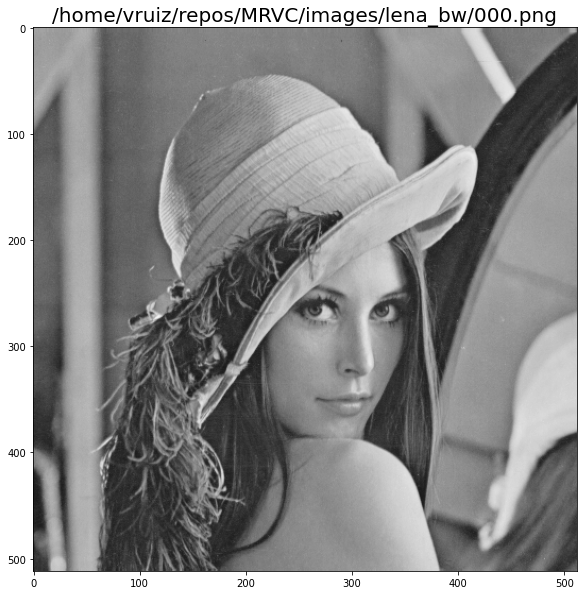

In [9]:
img = gray_image.read(fn, 0)
gray_image.show(img, fn + "000.png")

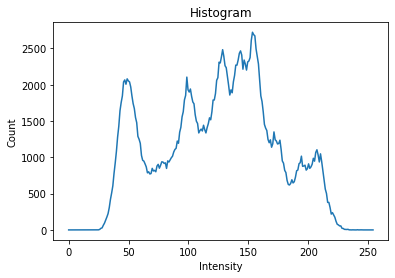

In [10]:
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))

plt.figure()
plt.title("Histogram")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.plot(bin_edges[0:-1], histogram)

## Bins and representation levels

In [11]:
QSS = 4 # Quantization Step Size

In [12]:
Q = quantizer(img, Q_step=QSS, min_val=np.min(img), max_val=np.max(img))
#Q = quantizer(img, Q_step=QSS, min_val=np.min(img), max_val=np.max(img), speedme=True)
print("decision_levels =", Q.get_decision_levels())
print("representation_levels =", Q.get_representation_levels())

decision_levels = [ 25.  35.  39.  43.  47.  50.  54.  57.  61.  65.  69.  73.  77.  81.
  85.  88.  92.  97. 100. 102. 104. 107. 110. 114. 118. 122. 125. 129.
 132. 135. 139. 142. 145. 148. 151. 154. 156. 159. 162. 165. 167. 171.
 174. 178. 182. 187. 191. 195. 199. 202. 205. 208. 211. 214. 219. 245.]
representation_levels = [ 32.89092141  37.75097691  41.66844624  45.57280042  49.00749064
  52.43304806  55.95851064  59.41118352  63.4578019   67.49042757
  71.47973179  75.49673574  79.49178562  83.54570038  87.02531646
  90.53849462  95.14285714  99.01307745 101.50546875 103.48931446
 105.95044578 108.97674419 112.50493274 116.55901269 120.57304374
 124.03628231 127.53170166 130.97749383 133.95676219 137.54683196
 141.01031827 143.99671593 147.01038163 150.01826684 153.04527763
 155.49841507 157.97112971 160.94838823 163.94983278 166.47649981
 169.48489933 172.96725177 176.48071217 180.41678643 185.01074279
 189.59922861 193.57977711 197.47926267 201.00192234 204.04311594
 207.05035279

In [13]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)
    plt.show(block=False)

In [14]:
x = np.linspace(0, 255, 500) # Input samples
y, k = Q.quan_dequan(x)
#plot(x, y, "Input Sample", "Reconstructed Sample", f"Lloyd-Max Quantizer ({fn}, $\Delta={QSS}$)")

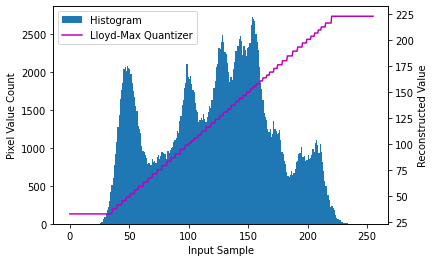

In [15]:
xlabel = "Input Sample"
ylabel = "Reconstructed Sample"
title = f"Lloyd-Max Quantizer ({fn}, $\Delta={QSS}$)"

ax1 = plt.subplot()
counts, bins = np.histogram(img, range(257))
l1 = ax1.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')

ax2 = ax1.twinx()
l2, = ax2.plot(x, y, color='m')

plt.legend([l1, l2], ["Histogram", "Lloyd-Max Quantizer"])
ax1.yaxis.set_label_text("Pixel Value Count")
ax2.yaxis.set_label_text("Reconstructed Value")
ax1.xaxis.set_label_text("Input Sample")
plt.show()

Notice that, in general, neither, the decision levels nor the representation levels are equally spaced. This is a direct consequence of the histogram of the input image. Thus, those input ranges where the number of gray-tones are more frequent, the resolution of the quantizer is increased. The representation levels are placed where the MSE is minimized.

## Visualize a quantization result

Used quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]
MSE = 1.0214328607005
SSIM = 0.9903629039349902
entropy = 5.667728663760444


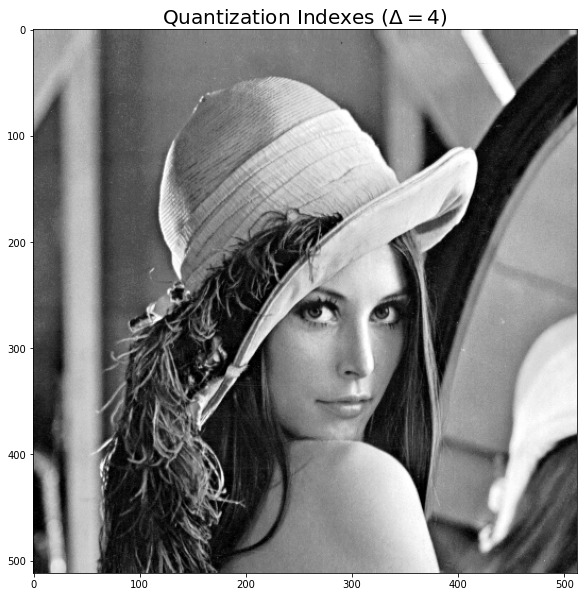

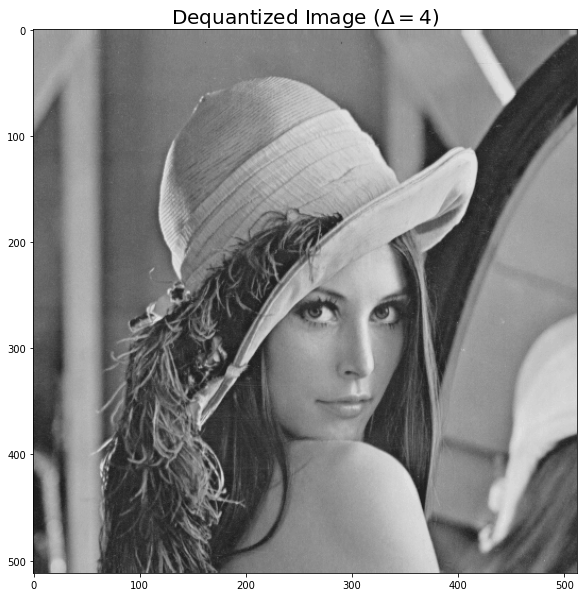

In [16]:
y, k = Q.quan_dequan(img)
print("Used quantization indexes:", np.unique(k))
gray_image.show_normalized(k, f"Quantization Indexes ($\\Delta={QSS}$)")
gray_image.show(y, f"Dequantized Image ($\\Delta={QSS}$)")
print("MSE =", distortion.MSE(img, y))
print("SSIM =", distortion.SSIM(img, y))
print("entropy =", information.entropy(k.flatten()))

### Explore the representation of the pallete

In [17]:
representation_levels = np.round(Q.get_representation_levels()).astype(np.uint8)
representation_levels

array([ 33,  38,  42,  46,  49,  52,  56,  59,  63,  67,  71,  75,  79,
        84,  87,  91,  95,  99, 102, 103, 106, 109, 113, 117, 121, 124,
       128, 131, 134, 138, 141, 144, 147, 150, 153, 155, 158, 161, 164,
       166, 169, 173, 176, 180, 185, 190, 194, 197, 201, 204, 207, 210,
       213, 217, 223], dtype=uint8)

In [18]:
representation_levels[1:]

array([ 38,  42,  46,  49,  52,  56,  59,  63,  67,  71,  75,  79,  84,
        87,  91,  95,  99, 102, 103, 106, 109, 113, 117, 121, 124, 128,
       131, 134, 138, 141, 144, 147, 150, 153, 155, 158, 161, 164, 166,
       169, 173, 176, 180, 185, 190, 194, 197, 201, 204, 207, 210, 213,
       217, 223], dtype=uint8)

In [19]:
representation_levels[::-1][0]

223

In [20]:
np.append(np.diff(representation_levels), representation_levels[::-1][0])

array([  5,   4,   4,   3,   3,   4,   3,   4,   4,   4,   4,   4,   5,
         3,   4,   4,   4,   3,   1,   3,   3,   4,   4,   4,   3,   4,
         3,   3,   4,   3,   3,   3,   3,   3,   2,   3,   3,   3,   2,
         3,   4,   3,   4,   5,   5,   4,   3,   4,   3,   3,   3,   3,
         4,   6, 223], dtype=uint8)

In [21]:
representation_levels = np.round(Q.get_representation_levels()).astype(np.uint8)
representation_levels_DPCM = np.append(np.diff(representation_levels), representation_levels[::-1][0]) # We start at the end!
print(representation_levels)
print(representation_levels_DPCM)
#with gzip.GzipFile("/tmp/representation_levels.npy.gz", "w") as f:
#    np.save(file=f, arr=representation_levels)
#np.save(file="/tmp/representation_levels.npy.gz", arr=representation_levels)

fileobj = open("/tmp/representation_levels.bin", mode='wb')
representation_levels.tofile(fileobj)
print("Bytes needed for the representation levels:", os.path.getsize("/tmp/representation_levels.bin"))

with gzip.GzipFile("/tmp/representation_levels.bin.gz", "w") as f:
    representation_levels.tofile(f)
print("Bytes needed for the representation levels in .gz format:", os.path.getsize("/tmp/representation_levels.bin.gz"))

fileobj = open("/tmp/representation_levels_DPCM.bin", mode='wb')
representation_levels_DPCM.tofile(fileobj)
print("Bytes needed for the representation levels DPCM:", os.path.getsize("/tmp/representation_levels_DPCM.bin"))

with gzip.GzipFile("/tmp/representation_levels_DPCM.bin.gz", "w") as f:
    representation_levels_DPCM.tofile(f)
print("Bytes needed for the representation levels DPCM in .gz format:", os.path.getsize("/tmp/representation_levels_DPCM.bin.gz"))


[ 33  38  42  46  49  52  56  59  63  67  71  75  79  84  87  91  95  99
 102 103 106 109 113 117 121 124 128 131 134 138 141 144 147 150 153 155
 158 161 164 166 169 173 176 180 185 190 194 197 201 204 207 210 213 217
 223]
[  5   4   4   3   3   4   3   4   4   4   4   4   5   3   4   4   4   3
   1   3   3   4   4   4   3   4   3   3   4   3   3   3   3   3   2   3
   3   3   2   3   4   3   4   5   5   4   3   4   3   3   3   3   4   6
 223]
Bytes needed for the representation levels: 55
Bytes needed for the representation levels in .gz format: 55
Bytes needed for the representation levels DPCM: 55
Bytes needed for the representation levels DPCM in .gz format: 60


All the encoding seems to perform similarly.

## RD curve
We compare two versions:
1. When the centroids are initialized using an scalar quantizer.
2. When the centroids are initialized at random.

Quantization indexes: [0 1]
N_bins=  2, rate=0.341705322265625 bits/pixel, distortion=  26.3
Quantization indexes: [0 1 2 3]
N_bins=  4, rate=0.770965576171875 bits/pixel, distortion=  12.7
Quantization indexes: [0 1 2 3 4 5 6 7]
N_bins=  8, rate=1.494842529296875 bits/pixel, distortion=   6.4
Quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
N_bins= 16, rate=2.820770263671875 bits/pixel, distortion=   3.4
Quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
N_bins= 32, rate=4.764984130859375 bits/pixel, distortion=   1.8
Quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
N_bins= 64, rate=6.240264892578125 bits/pixel, distortion=   1.1
Quantization indexes: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18

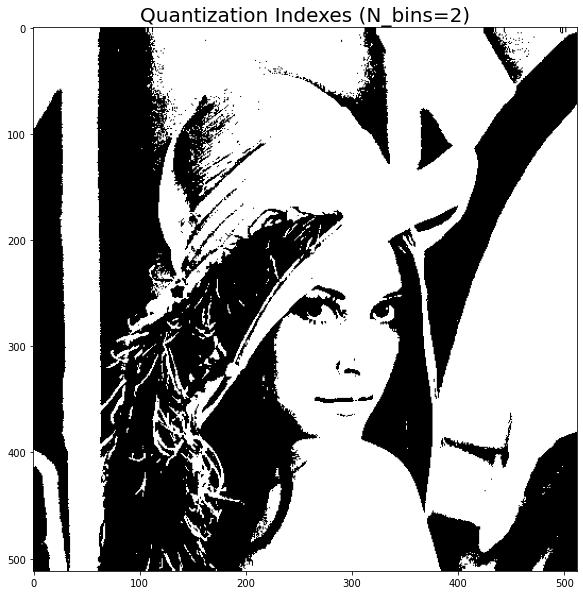

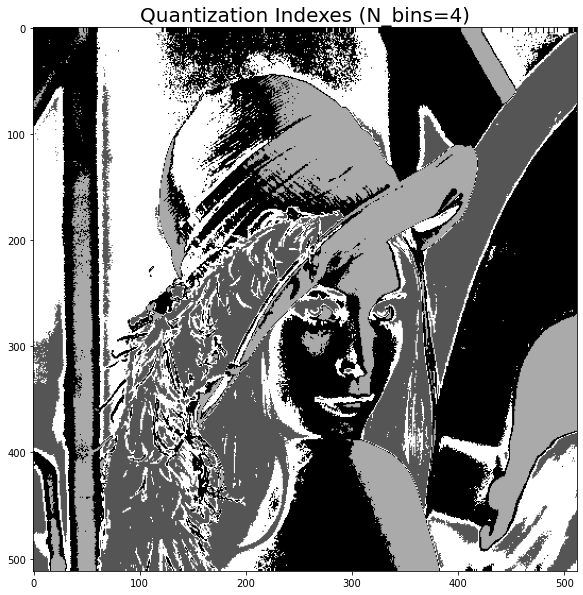

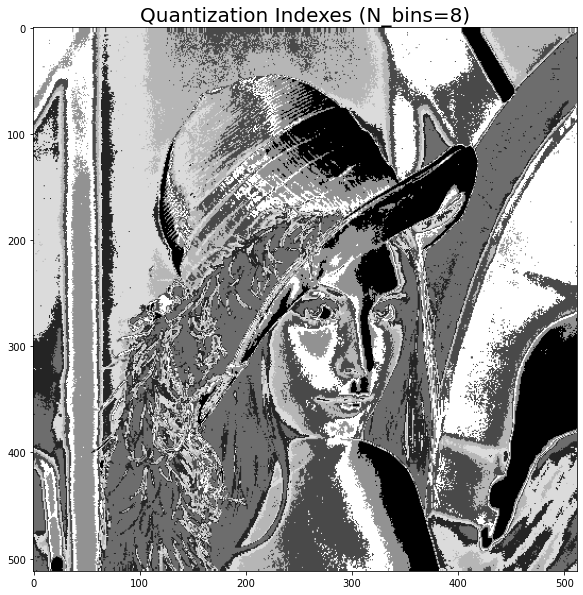

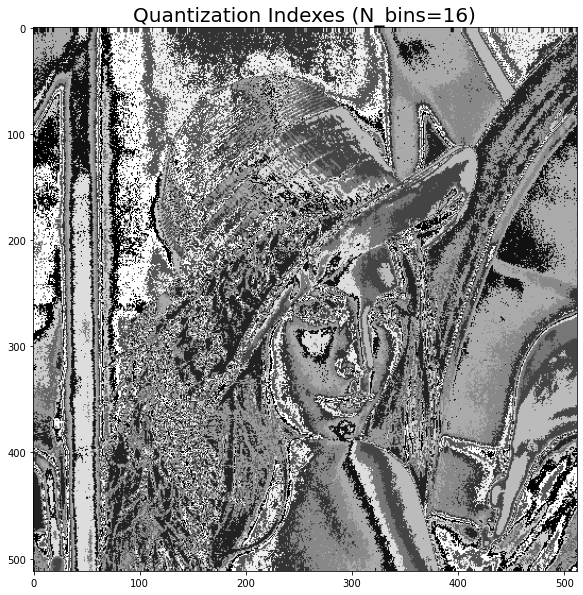

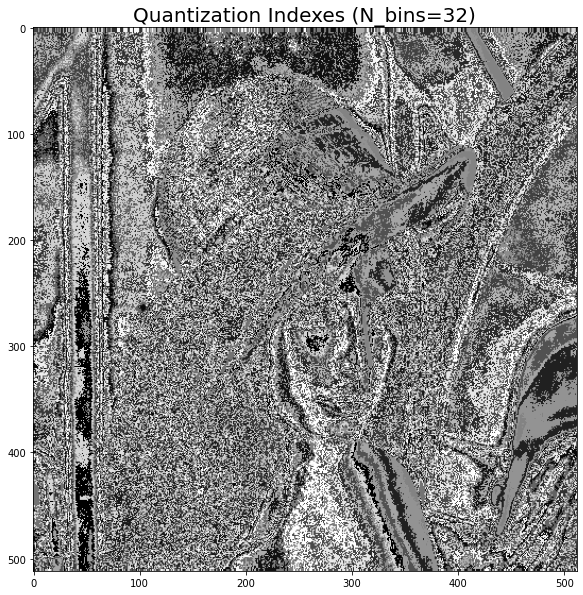

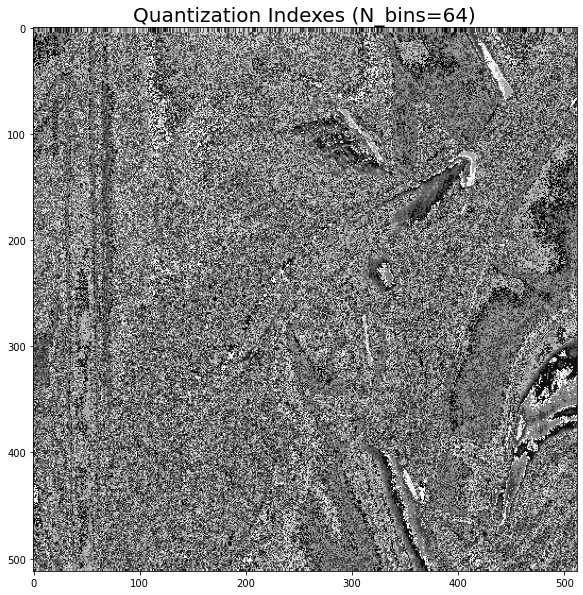

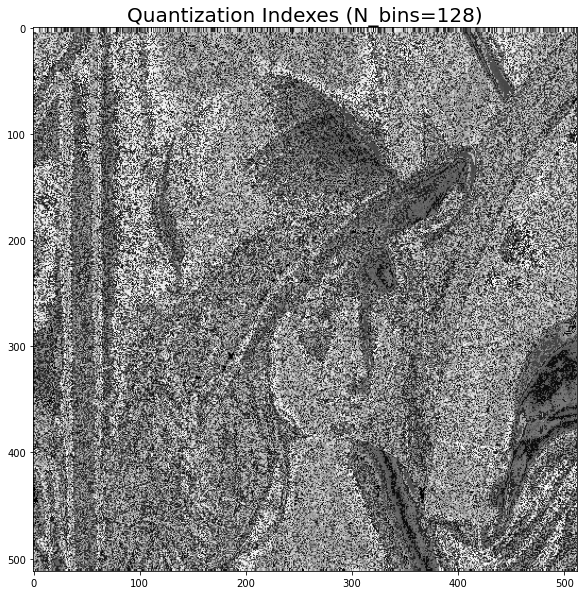

In [22]:
def RD_curve_random_init(img, N_bins):
    points = []
    flatten_img = img.reshape((-1, 1))  # flatten
    for n in N_bins:
        k_means = cluster.KMeans(n_clusters=n)
        k_means.fit(flatten_img)
        centroids = k_means.cluster_centers_.squeeze().astype(np.uint8)  # Centroids
        k = k_means.labels_.astype(np.uint8)  # Labels of the centroids
        y = centroids[k]
        y.shape = img.shape
        k.shape = img.shape
        print("Quantization indexes:", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(k.shape[0]*k.shape[1])
        with open("/tmp/representation_levels.uint8", mode="wb") as f:
            centroids.tofile(f)
        rate += (os.path.getsize("/tmp/representation_levels.uint8")*8/(k.shape[0]*k.shape[1]))
        #with gzip.GzipFile("/tmp/representation_levels.npy.gz", "w") as f:
        #    np.save(file=f, arr=centroids)
        #rate += (os.path.getsize("/tmp/representation_levels.npy.gz")*8/(k.shape[0]*k.shape[1]))
        _distortion = distortion.RMSE(img, y)
        #if n<16:
        #    plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
        #    plt.show()
        gray_image.show_normalized(k, f"Quantization Indexes (N_bins={n})")
        points.append((rate, _distortion))
        print(f"N_bins={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points
RD_points_random_init = RD_curve_random_init(img, N_bins)

Quantization indexes: [0 1]
N_bins=  2, rate=0.342132568359375 bits/pixel, distortion=  26.2
Quantization indexes: [0 1 2 3]
N_bins=  4, rate=0.682342529296875 bits/pixel, distortion=  12.7
Quantization indexes: [0 1 2 3 4 5 6 7]
N_bins=  8, rate=1.164703369140625 bits/pixel, distortion=   6.4
Quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
N_bins= 16, rate=1.86431884765625 bits/pixel, distortion=   3.4
Quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
N_bins= 32, rate=2.652191162109375 bits/pixel, distortion=   1.7
Quantization indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
N_bins= 64, rate=3.591094970703125 bits/pixel, distortion=   0.9
Quantization indexes: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18 

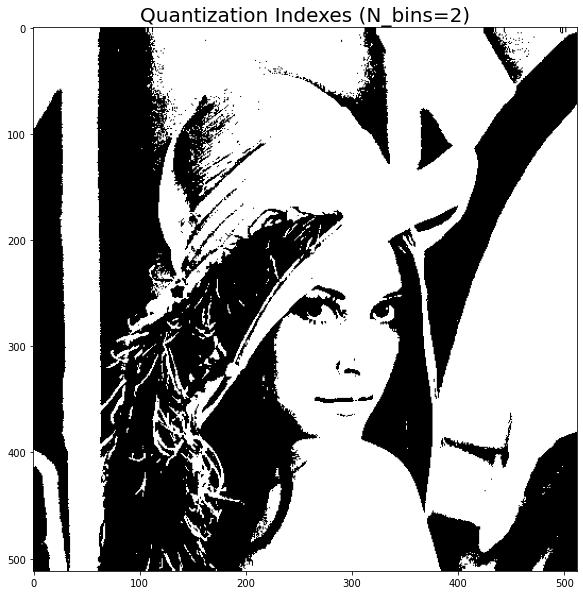

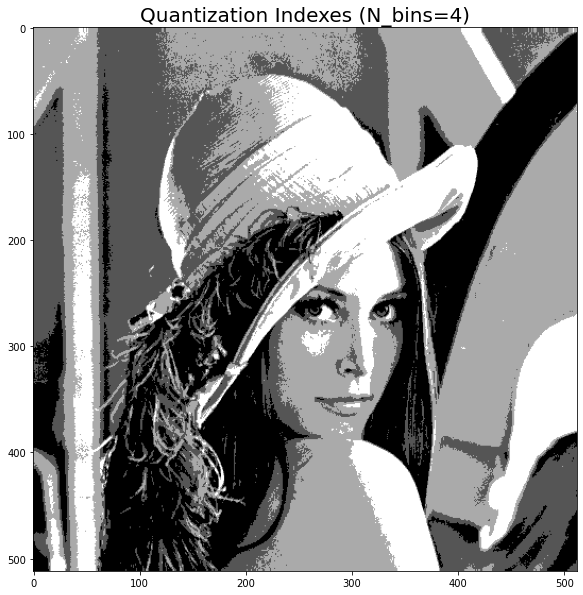

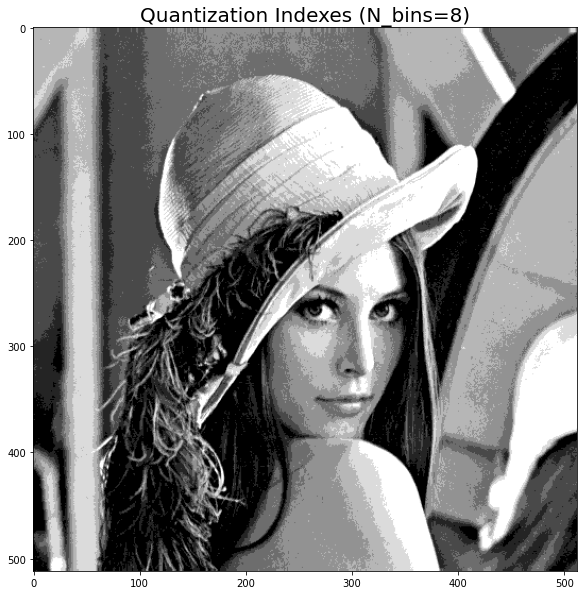

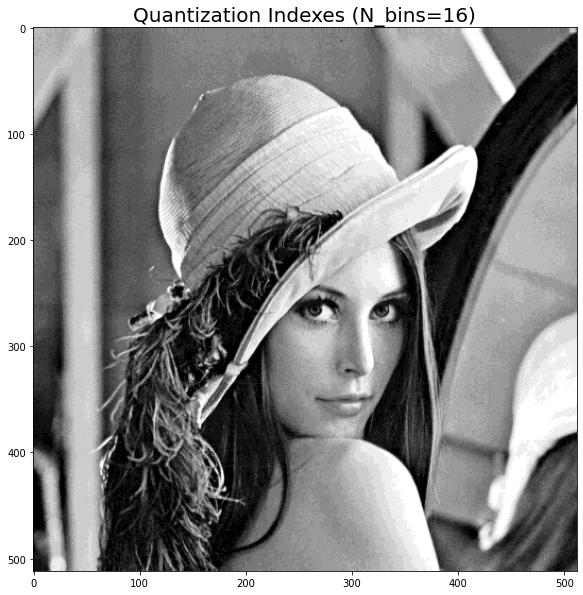

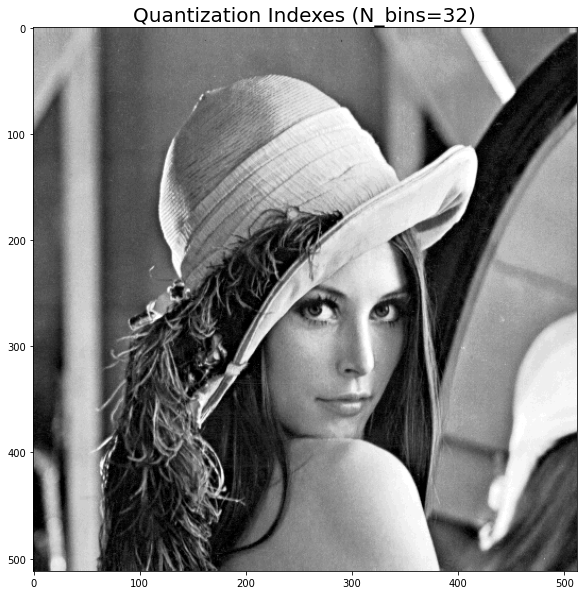

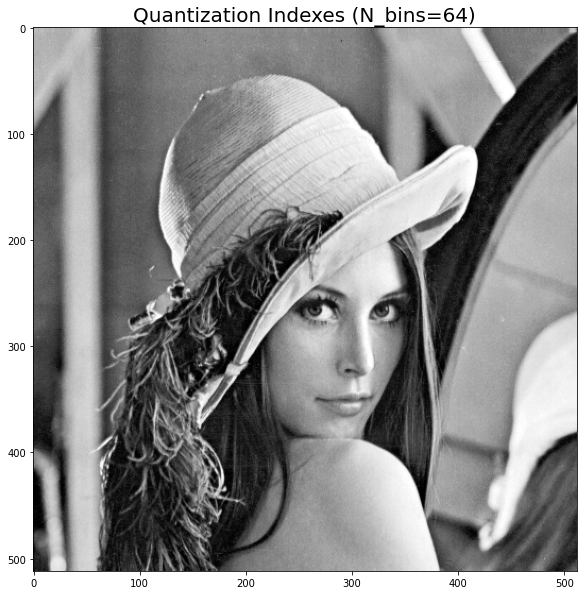

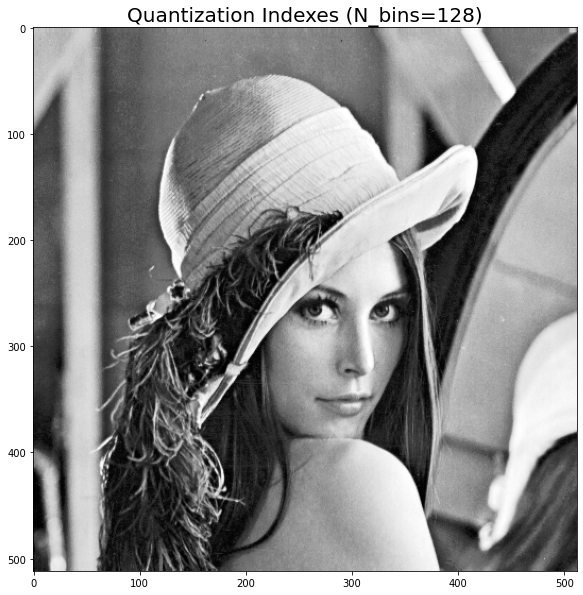

In [23]:
def RD_curve_sorted_labels(img, N_bins):
    points = []
    for n in N_bins:
        Q_step = 256//n
        Q = quantizer(img, Q_step=Q_step)
        y, k = Q.quan_dequan(img)
        print("Quantization indexes:", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(k.shape[0]*k.shape[1])
        with open("/tmp/representation_levels.uint8", mode="wb") as f:
            Q.get_representation_levels().tofile(f)
        rate += (os.path.getsize("/tmp/representation_levels.uint8")*8/(k.shape[0]*k.shape[1]))
        #with gzip.GzipFile("/tmp/representation_levels.npy.gz", "w") as f:
        #    np.save(file=f, arr=Q.get_representation_levels())
        #rate += (os.path.getsize("/tmp/representation_levels.npy.gz")*8/(k.shape[0]*k.shape[1]))
        #_distortion = distortion.RMSE(img, y)
        _distortion = distortion.RMSE(img, np.round(y).astype(np.uint8))
        gray_image.show_normalized(k, f"Quantization Indexes (N_bins={n})")
        #if n<16:
        #    plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
        #    plt.show()
        points.append((rate, _distortion))
        print(f"N_bins={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

RD_points_sorted_labels = RD_curve_sorted_labels(img, N_bins)

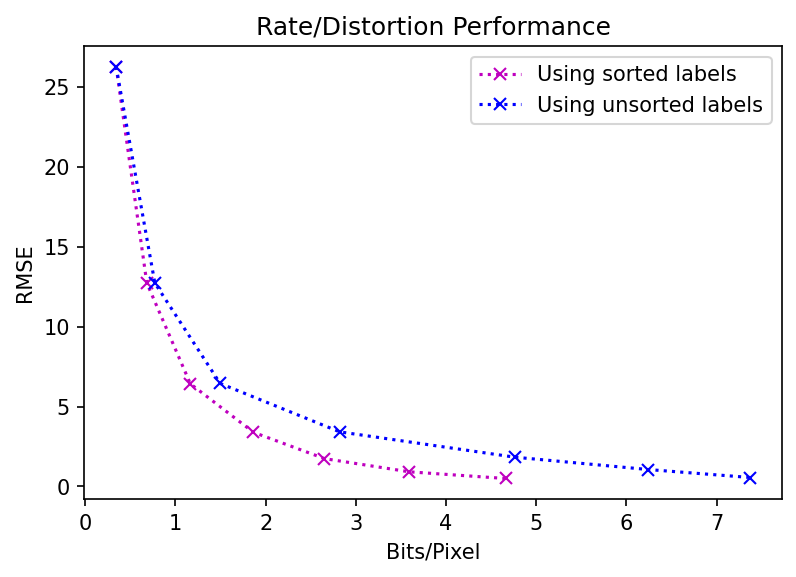

In [24]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_sorted_labels), c='m', marker='x', label="Using sorted labels", linestyle="dotted")
pylab.plot(*zip(*RD_points_random_init), c='b', marker='x', label="Using unsorted labels", linestyle="dotted")
pylab.title(f"Rate/Distortion Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

It is more efficient in terms of rate (and faster, because K-Means runs only one time) to initialize the centroids using the representation levels of a midtread quantizer. Notice that this disables the random selection of the initial centroids and therefore, it converts to K-means in a deterministic clustering algorithm.

In [25]:
with open(f"LloydMax_RD_points.txt", 'w') as f:
    for item in RD_points_sorted_labels:
        f.write(f"{item[0]}\t{item[1]}\n")

## Using [KMedoids](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html)

Selects one element of the input as the center for each cluster

In [26]:
def RD_curve_KMedoids(img, N_bins):
    points = []
    for n in N_bins:
        Q_step = 256//n
        Q = quantizer(img, Q_step=Q_step, select_an_input=True)
        y, k = Q.quan_dequan(img)
        print("Quantization indexes:", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(k.shape[0]*k.shape[1])
        with open("/tmp/representation_levels.uint8", mode="wb") as f:
            Q.get_representation_levels().tofile(f)
        rate += (os.path.getsize("/tmp/representation_levels.uint8")*8/(k.shape[0]*k.shape[1]))
        #with gzip.GzipFile("/tmp/representation_levels.npy.gz", "w") as f:
        #    np.save(file=f, arr=Q.get_representation_levels())
        #rate += (os.path.getsize("/tmp/representation_levels.npy.gz")*8/(k.shape[0]*k.shape[1]))
        #_distortion = distortion.RMSE(img, y)
        _distortion = distortion.RMSE(img, np.round(y).astype(np.uint8))
        gray_image.show_normalized(k, f"Quantization Indexes (N_bins={n})")
        #if n<16:
        #    plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
        #    plt.show()
        points.append((rate, _distortion))
        print(f"N_bins={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

RD_points_KMedoids = RD_curve_KMedoids(img, N_bins)

MemoryError: Unable to allocate 512. GiB for an array with shape (262144, 262144) and data type float64

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_sorted_labels), c='m', marker='x', label="KMeans", linestyle="dotted")
pylab.plot(*zip(*RD_points_KMedoids), c='b', marker='x', label="KMedoids", linestyle="dotted")
pylab.title(f"Rate/Distortion Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

In [ ]:
input()

## What happens if we increase the granuality?
Let's see the effect of using a finer quantization step (size).

In [ ]:
N_bins = [i for i in range(2, 128, 1)]
print(N_bins)

In [ ]:
def _(a, cmap, vmin, vmax):
    pass
plt.show = print
plt.imshow = _
RD_points_finer = RD_curve_sorted_labels(img, N_bins)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_sorted_labels), c='m', marker='x', label=f"Using powers of 2", linestyle="dotted")
pylab.plot(*zip(*RD_points_finer), c='g', marker='.', label=f"Using more quantization steps", linestyle="dotted")
pylab.title(fn)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

As it can be seen, the quantization steps that are powers of 2 describe reasonably well the convex hull of the RD curve.

## RDO (Rate Distortion Optimization) over the tile size

So far, the design of the Lloyd-Max quantizer has been independent of the rate (only the distortion has been minimized). However, the final RD performance of the encoding system depends on both opposed features (rate and distortion), generating a tradeoff that can be optimized under certain conditions.

For example, let's imagine that the image is quantized by tiles. Thus, in each tile, a "local" Lloyd-Max quantizer can be used, potentially decreasing the distortion (the histogram of a tile is more accurate describing the counts of the gray-scale values of the tile, than the histogram of the whole image). On the other hand, each tile requires at least a slighly different set of representation levels, aspect that will increase the rate (remember that in the case of the Lloyd-Max quantizer, the representation levels must be transmitted in the code-stream). Supposing that all the tiles have the same size, which tiling-configuration (tile size) is the most RD-efficient?

The following code determines the optimal tile size (in a linear and supposedly convex search space spawned by the side of the squared tiles, being the side a power of two) for different RD points. To determine the RD performance in a point $i$ of the RD curve (considering a RMSE VS bit-rate RD curve), we will use the [Lagrangian](https://en.wikipedia.org/wiki/Lagrange_multiplier):
$$
\mathbf{J}_i = \mathbf{D}_i + \mathbf{\lambda}_i \mathbf{R}_i,
$$
where $\mathbf{D}$ is a set of distortions (one for each point of the RD curve), $\mathbf{R}$ is a set of (bit-)rates (one for each point of the RD curve), and $\mathbf{\lambda}$ is known as a Lagrangian Multipler that controls the relative *importance* between $\mathbf{D}$ and $\mathbf{R}$ (that selects the $i$-th point of the RD curve). For example:
1. If $\mathbf{\lambda}_i=0$, and we are minimizing the Lagrangian, we are only interested in minimizing the distortion and therefore, we are "exploring" the bottom-right segment of the RD curve.
2. If $\mathbf{\lambda}_i=\infty$ (in the practice, a very large value) we are minimizing the RD tradeoff at the top-left segment of the RD curve (high compression ratio and probably, and a higher distortion).
3. Intermediate values of $\mathbf{\lambda}$ correspond to other internal points of the RD curve.

Finally, notice that we have defined $\mathbf{\lambda}_i$ as a continuous parameter, but the number of points of the RD curve is finite. Therefore, to determine $\mathbf{\lambda}_i$ for the point $i$ of the curve, we can define that:
$$
\mathbf{\lambda}_i = \frac{\mathbf{D}_i-\mathbf{D}_{i+1}}{\mathbf{R}_{i+1}-\mathbf{R}_i}
$$
and that:
$$
\mathbf{\lambda}_{(\Delta=1)}=0.
$$

Therefore, the idea is to find, given a $i$, which tile size is the optimal one (minimizes the Lagrangian). Such tile size must be encoded (represented in the code-stream).

In [ ]:
_lambda = []
for i in range(len(RD_points_sorted_labels)-1):
    _lambda.append((RD_points_sorted_labels[i][1] - RD_points_sorted_labels[i+1][1])/(RD_points_sorted_labels[i+1][0]-RD_points_sorted_labels[i][0]))
_lambda.append(_lambda[::-1][0]/2)  # Dividing by 2 is a good estimation when we are duplicating the number of bins with each point
print(_lambda)

In [ ]:
N_bins = [2, 4, 8, 16, 32, 64, 128] #range(2, 128, 1)

In [ ]:
tile_sides = [512, 256, 128, 64, 32, 16]
# The search space is small and a sequential search should be fast enough.

def optimize_tile_side(img, N_bins, tile_sides):
    print("img.shape =", img.shape)
    K = np.empty_like(img)
    Y = np.empty_like(img)
    J = np.empty(shape=(len(tile_sides), len(N_bins)))
    for tsc, ts in enumerate(tile_sides):
        print("ts =", ts)
        tiles_in_y = img.shape[0]//ts
        tiles_in_x = img.shape[1]//ts
        number_of_tiles = tiles_in_y*tiles_in_x
        print("tiles_in_y =", tiles_in_y)
        print("tiles_in_x =", tiles_in_x)
        for nc, n in enumerate(N_bins):
            Q_step = 256//n
            _distortion = 0
            rate = 0
            pallete = np.empty(shape=(tiles_in_y, tiles_in_x, n), dtype=np.uint8)
            for ty in range(tiles_in_y):
                for tx in range(tiles_in_x):
                    tile = img[ty*ts:(ty+1)*ts, tx*ts:(tx+1)*ts]
                    Q = quantizer(tile, Q_step=Q_step)
                    y, k = Q.quan_dequan(tile)
                    K[ty*ts:(ty+1)*ts, tx*ts:(tx+1)*ts] = k
                    Y[ty*ts:(ty+1)*ts, tx*ts:(tx+1)*ts] = np.rint(y)  # The representation levels are integers to minimize the data-overhead
                    representation_levels = np.rint(Q.get_representation_levels()).astype(np.uint8)
                    _distortion += distortion.RMSE(tile, y)
                    pallete[ty, tx, :] = np.append(np.diff(representation_levels), representation_levels[::-1][0])
            rate += gray_image.write(K, "/tmp/" + str(n) + '_', 0)*8/(img.shape[0]*img.shape[1])
            overhead = 0
            for i in range(n):
                overhead += gray_image.write(pallete[..., i], f"/tmp/pallete_bin={i}_Nbins={n}_", 0)*8/(img.shape[0]*img.shape[1])
            print("overhead =", overhead, "bits/pixel")
            _distortion /= number_of_tiles
            rate += overhead
            J[tsc, nc] = _distortion + _lambda[nc] * rate
            print(f"{tsc} {nc} ts={ts:>3} n={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f} J={J[tsc, nc]} lambda={_lambda[nc]}")
    return J

J = optimize_tile_side(img, N_bins, tile_sides)

In [ ]:
J

In [ ]:
optimal_ts = []
for nc in range(len(N_bins)):
    optimal_ts_index = np.argmin(J[..., nc])
    optimal_ts.append(tile_sides[optimal_ts_index])
print(optimal_ts)

In [ ]:
def optimal_RD_curve(img, N_bins, optimal_ts):
    K = np.empty_like(img)
    Y = np.empty_like(img)
    points = []
    for nc, n in enumerate(N_bins):
        ts = optimal_ts[nc]
        tiles_in_y = img.shape[0]//ts
        tiles_in_x = img.shape[1]//ts
        number_of_tiles = tiles_in_y*tiles_in_x
        Q_step = 256//n
        _distortion = 0
        rate = 0
        pallete = np.empty(shape=(tiles_in_y, tiles_in_x, n), dtype=np.uint8)
        for ty in range(tiles_in_y):
            for tx in range(tiles_in_x):
                #print("ty =", ty, "tx =", tx)
                tile = img[ty*ts:(ty+1)*ts, tx*ts:(tx+1)*ts]
                #print(tile.shape)
                Q = quantizer(tile, Q_step=Q_step, min_val=0, max_val=255)
                y, k = Q.quan_dequan(tile)
                K[ty*ts:(ty+1)*ts, tx*ts:(tx+1)*ts] = k
                Y[ty*ts:(ty+1)*ts, tx*ts:(tx+1)*ts] = np.rint(y)  # The representation levels are integers to minimize the data-overhead
                representation_levels = np.rint(Q.get_representation_levels()).astype(np.uint8)
                _distortion += distortion.RMSE(tile, y)
                pallete[ty, tx, :] = np.append(np.diff(representation_levels), representation_levels[::-1][0])
        rate += gray_image.write(K, "/tmp/" + str(n) + '_', 0)*8/(img.shape[0]*img.shape[1])
        overhead = 0
        for i in range(n):
            overhead += gray_image.write(pallete[..., i], f"/tmp/pallete_bin={i}_Nbins={n}_", 0)*8/(img.shape[0]*img.shape[1])
        print("overhead =", overhead, "bits/pixel")
        _distortion /= number_of_tiles
        rate += overhead
        points.append((rate, _distortion))
        print(f"n={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}, tile_side={ts}")
    return points

RDO_points = optimal_RD_curve(img, N_bins, optimal_ts)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_sorted_labels), label=f"No tiling", marker='o', linestyle="dotted")
pylab.plot(*zip(*RDO_points), label=f"Optimal Tiling", marker='o', linestyle="dotted")
pylab.title(f"Rate/Distortion Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

## Future work

### RDO over the "boundary" intensitiy values

Some value pixels of the image are in limit between bins. Those pixels are susceptible of being quantized in the closest bin, if the RD Lagrangian provides a higher slope.

Supposing that the impact on the RD curve of shift of the representation levels are independent (if we shift, for example, a decision level and the curve gets worse, this behaviour does not depend on any other possible shift in the rest of decision and representation levels), the following experiment optimizes the levels under the RD perspective.

In [ ]:
def optimize_levels(img, N_bins, search_range):
    points = []
    for n in N_bins:
        Q_step = 256//n
        Q = quantizer(img, Q_step=Q_step)
        y, k = Q.quan_dequan(img)
        #print("Quantization indexes:", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(k.shape[0]*k.shape[1])
        with open("/tmp/representation_levels.uint8", mode="wb") as f:
            Q.get_representation_levels().tofile(f)
        rate += (os.path.getsize("/tmp/representation_levels.uint8")*8/(k.shape[0]*k.shape[1]))
        #with gzip.GzipFile("/tmp/representation_levels.npy.gz", "w") as f:
        #    np.save(file=f, arr=Q.get_representation_levels())
        #rate += (os.path.getsize("/tmp/representation_levels.npy.gz")*8/(k.shape[0]*k.shape[1]))
        #_distortion = distortion.RMSE(img, y)
        _distortion = distortion.RMSE(img, np.round(y).astype(np.uint8))
        gray_image.show_normalized(k, f"Quantization Indexes (N_bins={n})")
        #if n<16:
        #    plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
        #    plt.show()
        points.append((rate, _distortion))
        print(f"N_bins={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

RDO_points = optimize_levels(img, N_bins)

In [ ]:
import time
while True:
    time.sleep(1)

## Ignore the rest ...

Probar a mover los representation levels, calculando el bit-rate. En teoría, los niveles de representación calculados por Kmeans deberían ser casi los que minimizan J, y por lo tanto, el espacio de búsqueda es pequeño.

In theory, it should be possible to design a RD-optimized Lloyd-Max quantizer for the whole image (so far, only D has beeb optimized) if instead of minimizing only the distortion we minimize the lagrangian:
$$
J = D + \lambda R
$$
for each possible input (gray level) value (supposing that the contribution to $R$ of each pixel will be proportional to the definitive $R$), for a given $\lambda$. Thus, we could build our optimized quantizer in three steps:
1. Use a Lloyd-Max quantizer to compute the D (in terms of the RMSE) and the average R (in terms of the entropy) of each gray-value of the image. This will generate a "J" 1D-array with 256 entries, that maps pixel values to J values.
2. Using the previous array, build a "J" 2D-array, replacing the pixel values by the corresponding J values.
3. Find the Lloyd-Max quantizer considering the J 2D-array.

To encode a pixel, we need to find the corresponding J value, and quantize this using the optimized quantizer. To decode an index, we need to find the pixel value that corresponds to the dequantized J value. For this, we need to use the 1D array that maps J values to pixel values.

Finally, notice that the quantizer must be optimized for a given $\lambda$.

In [ ]:
#tile_side = 128  # Must be a multiple of both dimensions of the image

def RD_curve(img, N_bins, tile_side):
    tiles_in_y = img.shape[0]//tile_side
    tiles_in_x = img.shape[1]//tile_side
    print("tile_side =", tile_side)
    print("tiles_in_y =", tiles_in_y)
    print("tiles_in_x =", tiles_in_x)
    number_of_tiles = tiles_in_y*tiles_in_x
    K = np.empty_like(img)
    Y = np.empty_like(img)
    points = []
    for n in N_bins:
        Q_step = 256//n
        _distortion = 0
        rate = 0
        prev_representation_levels = np.zeros(n, dtype=np.int8)
        pallete = np.empty(shape=(tiles_in_y, tiles_in_x, n), dtype=np.uint8)
        #print(prev_representation_levels.shape)
        for ty in range(tiles_in_y):
            for tx in range(tiles_in_x):
                tile = img[ty*tile_side:(ty+1)*tile_side, tx*tile_side:(tx+1)*tile_side]
                Q = quantizer(tile, Q_step=Q_step, min_val=0, max_val=255)
                #Q = quantizer(img, Q_step=Q_step, min_val=0, max_val=255)
                y, k = Q.quan_dequan(tile)
                K[ty*tile_side:(ty+1)*tile_side, tx*tile_side:(tx+1)*tile_side] = k
                Y[ty*tile_side:(ty+1)*tile_side, tx*tile_side:(tx+1)*tile_side] = np.rint(y)  # The representation levels are integers to minimize the data-overhead
                representation_levels = np.rint(Q.get_representation_levels()).astype(np.uint8)
                #print(representation_levels)
                #with gzip.GzipFile("/tmp/representation_levels.npy.gz", "w") as f:
                #    diff_representation_levels = representation_levels - prev_representation_levels
                #    np.save(file=f, arr=diff_representation_levels)
                #    print(representation_levels, prev_representation_levels, diff_representation_levels)
                #prev_representation_levels[:] = representation_levels
                #rate += (os.path.getsize("/tmp/representation_levels.npy.gz")*8/(img.shape[0]*img.shape[1]))
                _distortion += distortion.RMSE(tile, y)
                pallete[ty, tx, :] = np.append(np.diff(representation_levels), representation_levels[::-1][0])
                #pallete[ty, tx, :] = representation_levels
                #gray_image.show_normalized(pallete[..., 0], "")
                #with open("/tmp/representation_levels.uint8", mode="wb") as f:
                #    Q.get_representation_levels().tofile(f)
                #rate += (os.path.getsize("/tmp/representation_levels.uint8")*8/(img.shape[0]*img.shape[1]))
        rate += gray_image.write(K, "/tmp/" + str(n) + '_', 0)*8/(img.shape[0]*img.shape[1])
        overhead = 0
        for i in range(n):
            #print(pallete[..., i])
            overhead += gray_image.write(pallete[..., i], f"/tmp/pallete_bin={i}_Nbins={n}_", 0)*8/(img.shape[0]*img.shape[1])
        print("overhead =", overhead, "bits/pixel")
        _distortion /= number_of_tiles
        rate += overhead
        points.append((rate, _distortion))
        print(f"n={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
        gray_image.show_normalized(K, f"Quantization Indexes (n={n})")
        gray_image.show(Y, f"Reconstruction (n={n})")
        J = _distortion + _lambda[len(points)-1] * rate
        print("J =", J, _distortion, _lambda[len(points)-1],  rate)
    return points

RDO_points_256 = RD_curve(img, N_bins, 256)
RDO_points_128 = RD_curve(img, N_bins, 128)
RDO_points_64 = RD_curve(img, N_bins, 64)
RDO_points_32 = RD_curve(img, N_bins, 32)
#RDO_points_16 = RD_curve(img, N_bins, 16)


It is posible to improve the RD curve using stocastic search? The idea is to, given a K-Means solution, perform a (finite) number of training steps of the classifier with the hope of finding a better one (remember that K-Means obtains different solutions when it is run several times). If this happens, the process is repeated. Otherwise, we stop.

To determine if the current classifier is better than the previous one, we can use a Lagrangian Multiplier
$$
J = D+\lambda R,
$$
where the tradeoff between rate (R) and distortion (D) is quantified for a given slope $\lambda$. Thus, the smaller the $J$, the better the classifier.

In [ ]:
class RDO(quantization.LloydMax_Quantizer):

    def __init__(img, Q_step, max_number_of_iters, _lambda):
        self.Q = super().__init__(img, Q_step=QS, min_val=0, max_val=255)
        self.img = img
        self.Q_step = Q_step
        self.max_number_of_iters = max_number_of_iters
        #self.lambda = _lambda

    def RDO_step():
        y, k = self.Q.quan_dequan(self.img)
        R = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(k.shape[0]*k.shape[1])
        D = distortion.RMSE(img, y)
        current_J = D + _lambda * R
        next_Q = self.quantizer(self.img, Q_step=self.Q_step, min_val=0, max_val=255)
        y, k = next_Q.quan_dequan(self.img)
        R = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(k.shape[0]*k.shape[1])
        D = distortion.RMSE(img, y)
        next_J = D + _lambda * R
        if next_J < current_J:
            return next_Q
        else:
            return current_Q

    def RDO():
        Q = self.quantizer(self.img, Q_step=self.Q_step, min_val=0, max_val=255)
        for i in range(max_number_of_iters):
            Q = RDO_step(Q)
        return Q

In [ ]:
import copy

def optimize_step(Q, Q_step, _lambda):
    print("Q.get_representation_levels=", Q.get_representation_levels())
    y, k = Q.quan_dequan(img)
    R = gray_image.write(k, "/tmp/" + str(Q_step) + '_Q_', 0)*8/(k.shape[0]*k.shape[1])
    D = distortion.RMSE(img, y)
    current_J = D + _lambda * R
    next_Q = copy.deepcopy(Q)
    next_Q.retrain(img)
    print("next_Q.get_representation_levels=", next_Q.get_representation_levels())
    #next_Q = quantizer(img, Q_step=Q_step, min_val=0, max_val=255)
    y, k = next_Q.quan_dequan(img)
    R = gray_image.write(k, "/tmp/" + str(Q_step) + '_next_Q_', 0)*8/(k.shape[0]*k.shape[1])
    D = distortion.RMSE(img, y)
    next_J = D + _lambda * R
    print(current_J, next_J)
    if next_J < current_J:
         return next_Q
    else:
         return Q

def optimize(Q, Q_step, _lambda, max_number_of_iters):
    #ext_Q = quantizer(img, Q_step, min_val=0, max_val=255)
    for i in range(max_number_of_iters):
        Q = optimize_step(Q, Q_step, _lambda)
    return Q

In [ ]:
N_bins = 32
Q_step = 256//N_bins
max_number_of_iters = 10
N_bins = [2, 4, 8, 16, 32, 64, 128]
_lambda = 200

def RDO_curve(img, N_bins):
    points = []
    for n in N_bins:
        Q_step = 256//n
        Q = quantizer(img, Q_step=Q_step, min_val=0, max_val=255)
        Q = optimize(Q, Q_step, max_number_of_iters, _lambda)
        y, k = Q.quan_dequan(img)
        print("Quantization indexes: ", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(n) + '_', 0)*8/(k.shape[0]*k.shape[1])
        _distortion = distortion.RMSE(img, y)
        if n<16:
            plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
            plt.show()
        points.append((rate, _distortion))
        print(f"n={n:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

RDO_points = RDO_curve(img, N_bins)

In [ ]:
np.random.seed(0)  # makes the random numbers predictable
flatten_img = img.reshape((-1, 1))  # flatten
k_means = cluster.KMeans(n_clusters=n_clusters, n_init=N_tries)
k_means.fit(flatten_img)  # train
centroids = k_means.cluster_centers_.squeeze()  # Centroids
print("centroids =", centroids)
labels = k_means.labels_  # Labels of the centroids
labels.shape = img.shape
print(len(labels), len(centroids), img.shape, n_clusters, len(centroids.flatten()))
gray_image.show_normalized(labels, "Labels")

Notice that the indexes (labels) are not sorted by the corresponding intensity values.

In [ ]:
# create an array from labels and values
#img_dequantized = np.choose(labels, centroids)
#img_dequantized = centroids[range(len(labels)), labels]
#img_dequantized = np.empty_like(flatten_img)
#for i in range(len(labels)):
#    img_dequantized[i] = centroids[labels[i]]
#img_dequantized = centroids[labels[range(len(labels))]]
img_dequantized = centroids[labels]
#img_dequantized.shape = img.shape

print("labels", labels, labels.shape)
print("max and min dequantized image", img_dequantized.max(), img_dequantized.min())
prediction = k_means.predict(flatten_img)  # Quantize
prediction.shape = img.shape
print("prediction =", prediction)
print("prediction.shape =", prediction.shape)

vmin = img.min()
vmax = img.max()

gray_image.show(img_dequantized, "Dequantized")
new_img_dequantized = centroids[prediction]
gray_image.show(new_img_dequantized, "New Dequantized")